In [74]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp # for reference
import autograd.numpy.random as npr

import autograd.numpy as np
from neuralsolver import NNSolver

import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
import time

# figure settings
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['legend.fontsize'] = 13

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 15

# Problem Definition

In [59]:
# define ODE problem
# 2 species Lotka–Volterra equations

def f(t, y):
    # du/dt = au -buv
    # dv/dt = -cv + dbu*v
    # http://scipy-cookbook.readthedocs.io/items/LoktaVolterraTutorial.html
    a = 1.
    b = 0.1
    c = 1.5
    d = 0.75
    return [a*y[0] - b*y[0]*y[1], -c*y[1]+d*b*y[0]*y[1]]

t = np.linspace(0, 10, 100).reshape(-1, 1) #increase training points

y0_list = [5, 10] # number of prey and predactor respectively

# Reference solution

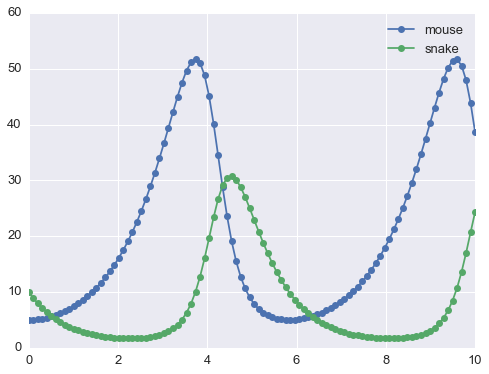

In [60]:
# reference solution using scipy package
sol = solve_ivp(f, [t.min(), t.max()], y0_list, 
                t_eval=t.ravel(), method='Radau', rtol=1e-5)
plt.plot(sol.t, sol.y[0], marker='o', label='mouse')
plt.plot(sol.t, sol.y[1], marker='o', label='snake')
#plt.plot(sol.t, sol.y[2], marker = 'o', label = 'owl')
plt.legend()

# Neural Net Training

In [65]:
nn = NNSolver(f, t, y0_list, n_hidden=50)
nn

Neural ODE Solver 
Number of equations:       2 
Initial condition y0:      [5, 10] 
Numnber of hidden units:   50 
Number of training points: 100 

In [66]:
nn.reset_weights()
%time nn.train(maxiter=500, iprint=100)

iteration: 0 loss:  159.635654021
iteration: 100 loss:  1.39846776261
iteration: 200 loss:  0.793936073844
iteration: 300 loss:  0.0598253061071
iteration: 400 loss:  0.018242389558
         Current function value: 0.013039
         Iterations: 500
         Function evaluations: 578
         Gradient evaluations: 578
CPU times: user 12.5 s, sys: 169 ms, total: 12.7 s
Wall time: 9.89 s


# Verifying training set

In [67]:
y_pred_list, dydt_pred_list = nn.predict()

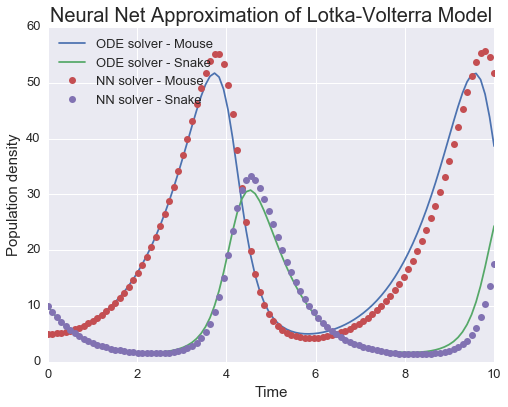

In [68]:
#y_pred_list, dydt_pred_list = nn.predict()
plt.figure(figsize= (8, 6))
# scipy sol
plt.plot(sol.t, sol.y[0], label='ODE solver - Mouse')
plt.plot(sol.t, sol.y[1], label='ODE solver - Snake')
#plt.plot(sol.t, sol.y[2], label='ODE solver - Owl')
# nn soln

plt.plot(t, y_pred_list[0], 'o', label='NN solver - Mouse')


plt.plot(t, y_pred_list[1], 'o', label='NN solver - Snake')


#plt.plot(t, y_pred_list[2], 'o', label='NN - Owl')

plt.legend(loc = "best")
plt.title('Neural Net Approximation of Lotka-Volterra Model')
plt.xlabel('Time')
plt.ylabel('Population density')
#plt.xlim((0, 10.1))

In [69]:
np.mean([sqrt(mean_squared_error(sol.y[i], y_pred_list[i])) for i in range(2)])
#rms = sqrt(mean_squared_error(sol.y[0], y_pred_list[0]))
#sqrt(mean_squared_error(sol.y[1], y_pred_list[1])) + sqrt(mean_squared_error(sol.y[0], y_pred_list[0]))

2.2040291040858606

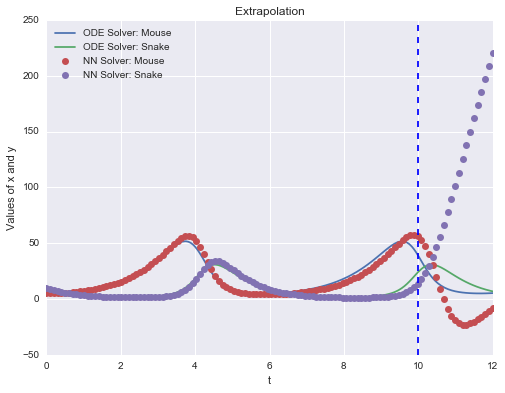

In [48]:
# not used
t_test = np.linspace(0., 12.0, 120).reshape(-1,1)

sol = solve_ivp(f, [t_test.min(), t_test.max()], y0_list, method='Radau', rtol=1e-5)
y_pred_list, dydt_pred_list = nn.predict(t=t_test)
plt.figure(figsize=(8, 6))
plt.plot(sol.t, sol.y[0], label='ODE Solver: Mouse')
plt.plot(sol.t, sol.y[1], label='ODE Solver: Snake')

plt.plot(t_test, y_pred_list[0], 'o', label='NN Solver: Mouse')
plt.plot(t_test, y_pred_list[1], 'o', label='NN Solver: Snake')
plt.axvline(x = 10 , linestyle = '--')
plt.legend(loc = 'best')
plt.title('Extrapolation')
plt.ylabel('Values of x and y')
plt.xlabel('t')

# Performance over 100 Fittings

In [77]:
res_arr = []
for _ in range(100):
    nn = NNSolver(f, t, y0_list, n_hidden=20)
    nn.reset_weights()
    nn.train(maxiter=500)
    y_pred_list, dydt_pred_list = nn.predict()
    res_arr.append(np.mean([sqrt(mean_squared_error(sol.y[i], y_pred_list[i])) for i in range(2)]))
    

iteration: 0 loss:  68.5346892721
iteration: 200 loss:  0.430112130296
iteration: 400 loss:  0.0408983454309
         Current function value: 0.018267
         Iterations: 500
         Function evaluations: 560
         Gradient evaluations: 560
iteration: 0 loss:  3179.42198992
         Current function value: 0.892373
         Iterations: 126
         Function evaluations: 175
         Gradient evaluations: 164
iteration: 0 loss:  410.003334667
iteration: 200 loss:  0.018639447138
         Current function value: 0.009502
         Iterations: 256
         Function evaluations: 321
         Gradient evaluations: 309
iteration: 0 loss:  806.565986083
iteration: 200 loss:  0.642357619223
iteration: 400 loss:  0.0725049385395
         Current function value: 0.066963
         Iterations: 500
         Function evaluations: 547
         Gradient evaluations: 547
iteration: 0 loss:  1719.2730113
         Current function value: 0.391482
         Iterations: 149
         Function evaluations

(array([  8.,  19.,   5.,   5.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
         1.,  57.,   1.,   2.]), array([  0.52799164,   1.99199339,   3.45599514,   4.91999688,
         6.38399863,   7.84800038,   9.31200213,  10.77600387,
        12.24000562,  13.70400737,  15.16800912,  16.63201086,
        18.09601261,  19.56001436,  21.02401611,  22.48801785]), <a list of 15 Patch objects>)


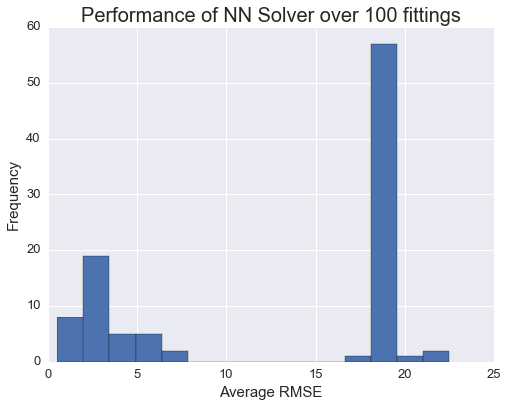

In [78]:
figr = plt.hist(res_arr, bins=15)
plt.title('Performance of NN Solver over 100 fittings')
plt.xlabel('Average RMSE')
plt.ylabel('Frequency')
print (figr)

## Compare across optimization techniques

In [75]:
def plot_loss_compare(model, maxiter = 1000, iprint = 200):
    model.reset_weights()
    save_init_paras_list = model.params_list
    save_init_flattened_params = model.flattened_params
    
    
    methods = ['CG','BFGS','L-BFGS-B']
    
    plt.figure(figsize=(8,6))
    for method in methods:
        
        model.params_list = save_init_paras_list
        model.flattened_params = save_init_flattened_params
        
        start_time = time.time()
        model.train(method = method, maxiter=maxiter, iprint=iprint)
        duration = time.time() - start_time
        
        plt.semilogy(range(len(model.loss)), model.loss, label = method + ' (time = {}s'.format(round(duration,2)) + ')')
        
    plt.legend()
    plt.title("Log Loss Comparision")
    plt.xlabel("Iteration")
    plt.ylabel("Log Loss")
    plt.show()

iteration: 0 loss:  13784.0200561
iteration: 200 loss:  2.95015333502
iteration: 400 loss:  2.66456519599
iteration: 600 loss:  2.46004355524
iteration: 800 loss:  2.36099840809
         Current function value: 2.266590
         Iterations: 1000
         Function evaluations: 1870
         Gradient evaluations: 1870
iteration: 0 loss:  13784.0200561
iteration: 200 loss:  0.242444304938
iteration: 400 loss:  0.00603674272292
iteration: 600 loss:  0.00198928363787
iteration: 800 loss:  0.000825909125521
         Current function value: 0.000452
         Iterations: 1000
         Function evaluations: 1128
         Gradient evaluations: 1128
iteration: 0 loss:  13500.8614112
iteration: 200 loss:  2.45535806558
iteration: 400 loss:  2.45035910906
iteration: 600 loss:  2.44585730525
iteration: 800 loss:  2.44175753237
iteration: 1000 loss:  2.43875173389


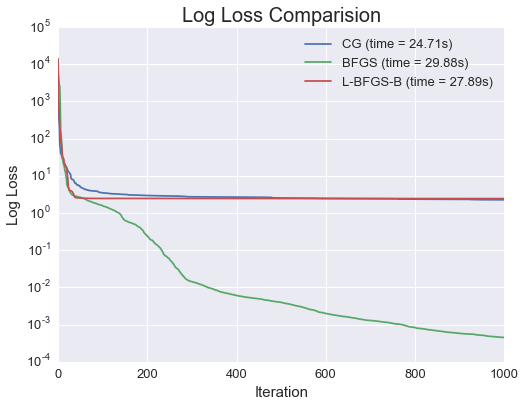

In [76]:
plot_loss_compare(nn)